# Forced Photometry Simulation and Validation

This notebook simulates a science field with known sources and verifies that forced photometry can recover expected fluxes.

## Overview

1. Create synthetic FITS images with Gaussian sources at known positions
2. Perform forced photometry at catalog positions
3. Compare measured vs expected fluxes
4. Visualize results

In [1]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

import sys
# Handle both script and notebook execution
try:
    # Try using __file__ if available (script execution)
    sys.path.append(str(Path(__file__).resolve().parent.parent / "src"))
except NameError:
    # __file__ not available in Jupyter notebooks, use cwd instead
    # Notebook is in notebooks/, module is in src/dsa110_contimg/
    sys.path.append(str(Path.cwd().parent / "src"))

from dsa110_contimg.photometry.forced import measure_forced_peak, ForcedPhotometryResult

## Helper Function: Create Synthetic FITS Image

In [2]:
def create_synthetic_fits(
    output_path: Path,
    center_ra: float = 180.0,  # degrees
    center_dec: float = 35.0,   # degrees
    image_size: int = 512,
    pixel_scale: float = 0.001,  # degrees per pixel (~3.6 arcsec)
    beam_fwhm_pix: float = 3.0,  # pixels (Gaussian FWHM)
    rms_noise_jy: float = 0.001,  # Jy/beam RMS noise
    sources: list = None,
) -> Path:
    """
    Create a synthetic FITS image with Gaussian sources.
    """
    if sources is None:
        sources = [
            {"ra_deg": 180.0, "dec_deg": 35.0, "flux_jy": 1.0, "name": "bright_center"},
            {"ra_deg": 180.01, "dec_deg": 35.01, "flux_jy": 0.5, "name": "medium_offset"},
            {"ra_deg": 179.99, "dec_deg": 34.99, "flux_jy": 0.2, "name": "faint_offset"},
            {"ra_deg": 180.005, "dec_deg": 35.005, "flux_jy": 0.1, "name": "faint_close"},
        ]
    
    data = np.zeros((image_size, image_size), dtype=np.float32)
    
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [image_size / 2.0, image_size / 2.0]
    wcs.wcs.crval = [center_ra, center_dec]
    wcs.wcs.cdelt = [-pixel_scale, pixel_scale]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    wcs.wcs.cunit = ["deg", "deg"]
    
    y_coords, x_coords = np.ogrid[0:image_size, 0:image_size]
    sigma_pix = beam_fwhm_pix / (2 * np.sqrt(2 * np.log(2)))
    
    for src in sources:
        ra_src = src["ra_deg"]
        dec_src = src["dec_deg"]
        flux_src = src["flux_jy"]
        
        pix_coords = wcs.world_to_pixel_values(ra_src, dec_src)
        x0, y0 = float(pix_coords[0]), float(pix_coords[1])
        
        if not (0 <= x0 < image_size and 0 <= y0 < image_size):
            print(f"Warning: Source {src.get('name', 'unknown')} outside bounds")
            continue
        
        gaussian = flux_src * np.exp(
            -((x_coords - x0) ** 2 + (y_coords - y0) ** 2) / (2 * sigma_pix ** 2)
        )
        data += gaussian
    
    noise = np.random.normal(0.0, rms_noise_jy, data.shape).astype(np.float32)
    data += noise
    
    hdu = fits.PrimaryHDU(data=data)
    hdu.header.update(wcs.to_header())
    hdu.header["BUNIT"] = "Jy/beam"
    hdu.header["BMAJ"] = beam_fwhm_pix * pixel_scale * 3600
    hdu.header["BMIN"] = beam_fwhm_pix * pixel_scale * 3600
    hdu.header["BPA"] = 0.0
    
    hdu.writeto(output_path, overwrite=True)
    return output_path

print("Function defined: create_synthetic_fits")

Function defined: create_synthetic_fits


## Create Test Science Field

In [3]:
# Query NVSS sources around 0834+555
# 0834+555 means RA=08:34, Dec=+55:30 (approximately)
# Convert to degrees: RA = 8h 34m = 8.5667h = 128.5 deg, Dec = 55.5 deg
from dsa110_contimg.catalog.query import query_sources

calibrator_ra = 128.5  # 08:34 in degrees
calibrator_dec = 55.5  # +55:30 in degrees

print("Querying NVSS catalog around 0834+555...")
nvss_sources = query_sources(
    catalog_type="nvss",
    ra_center=calibrator_ra,
    dec_center=calibrator_dec,
    radius_deg=0.5,  # 0.5 degree radius field
    min_flux_mjy=5.0,  # Minimum 5 mJy
    max_sources=50,  # Limit to top 50 sources
)

print(f"Found {len(nvss_sources)} NVSS sources in the field")

# Convert NVSS sources to test_sources format
# NVSS flux is in mJy, convert to Jy
test_sources = []
for idx, row in nvss_sources.iterrows():
    flux_jy = row['flux_mjy'] / 1000.0  # Convert mJy to Jy
    source_name = f"nvss_{idx}" if 'name' not in row else row.get('name', f"nvss_{idx}")
    test_sources.append({
        "ra_deg": float(row['ra_deg']),
        "dec_deg": float(row['dec_deg']),
        "flux_jy": flux_jy,
        "name": source_name,
    })

# Sort by flux descending
test_sources.sort(key=lambda x: x['flux_jy'], reverse=True)

# Use the brightest source as field center, or use calibrator position
if test_sources:
    center_ra = test_sources[0]['ra_deg']
    center_dec = test_sources[0]['dec_deg']
else:
    center_ra = calibrator_ra
    center_dec = calibrator_dec

# Create output directory
output_dir = Path("notebook_outputs")
output_dir.mkdir(exist_ok=True)

# Create synthetic FITS image
fits_path = output_dir / "test_science_field_0834+555.fits"
create_synthetic_fits(
    fits_path,
    center_ra=center_ra,
    center_dec=center_dec,
    image_size=512,
    pixel_scale=0.001,
    beam_fwhm_pix=3.0,
    rms_noise_jy=0.001,
    sources=test_sources,
)

print(f"\nCreated synthetic FITS image: {fits_path}")
print(f"Field center: RA={center_ra:.5f}°, Dec={center_dec:.5f}°")
print(f"Image size: 512x512 pixels")
print(f"Pixel scale: 0.001 deg/pixel (~3.6 arcsec/pixel)")
print(f"Beam FWHM: 3 pixels")
print(f"RMS noise: 0.001 Jy/beam")
print(f"\nNVSS sources in field ({len(test_sources)} total):")
for src in test_sources[:10]:  # Show top 10
    print(f"  {src['name']:20s}: RA={src['ra_deg']:8.5f}, Dec={src['dec_deg']:8.5f}, "
          f"Flux={src['flux_jy']:6.3f} Jy")
if len(test_sources) > 10:
    print(f"  ... and {len(test_sources) - 10} more sources")

Querying NVSS catalog around 0834+555...
Found 18 NVSS sources in the field

Created synthetic FITS image: notebook_outputs/test_science_field_0834+555.fits
Field center: RA=128.72879°, Dec=55.57250°
Image size: 512x512 pixels
Pixel scale: 0.001 deg/pixel (~3.6 arcsec/pixel)
Beam FWHM: 3 pixels
RMS noise: 0.001 Jy/beam

NVSS sources in field (18 total):
  nvss_NVSS J083454+553421: RA=128.72879, Dec=55.57250, Flux= 8.283 Jy
  nvss_NVSS J083620+552858: RA=129.08492, Dec=55.48294, Flux= 0.288 Jy
  nvss_NVSS J083122+552858: RA=127.84554, Dec=55.48303, Flux= 0.066 Jy
  nvss_NVSS J083657+553842: RA=129.24071, Dec=55.64508, Flux= 0.025 Jy
  nvss_NVSS J083704+553931: RA=129.26779, Dec=55.65872, Flux= 0.016 Jy
  nvss_NVSS J083622+552930: RA=129.09446, Dec=55.49181, Flux= 0.014 Jy
  nvss_NVSS J083426+555918: RA=128.61046, Dec=55.98842, Flux= 0.012 Jy
  nvss_NVSS J083245+550621: RA=128.19154, Dec=55.10597, Flux= 0.011 Jy
  nvss_NVSS J083309+550634: RA=128.29100, Dec=55.10964, Flux= 0.009 Jy
  nvs

## Visualize the Synthetic Image

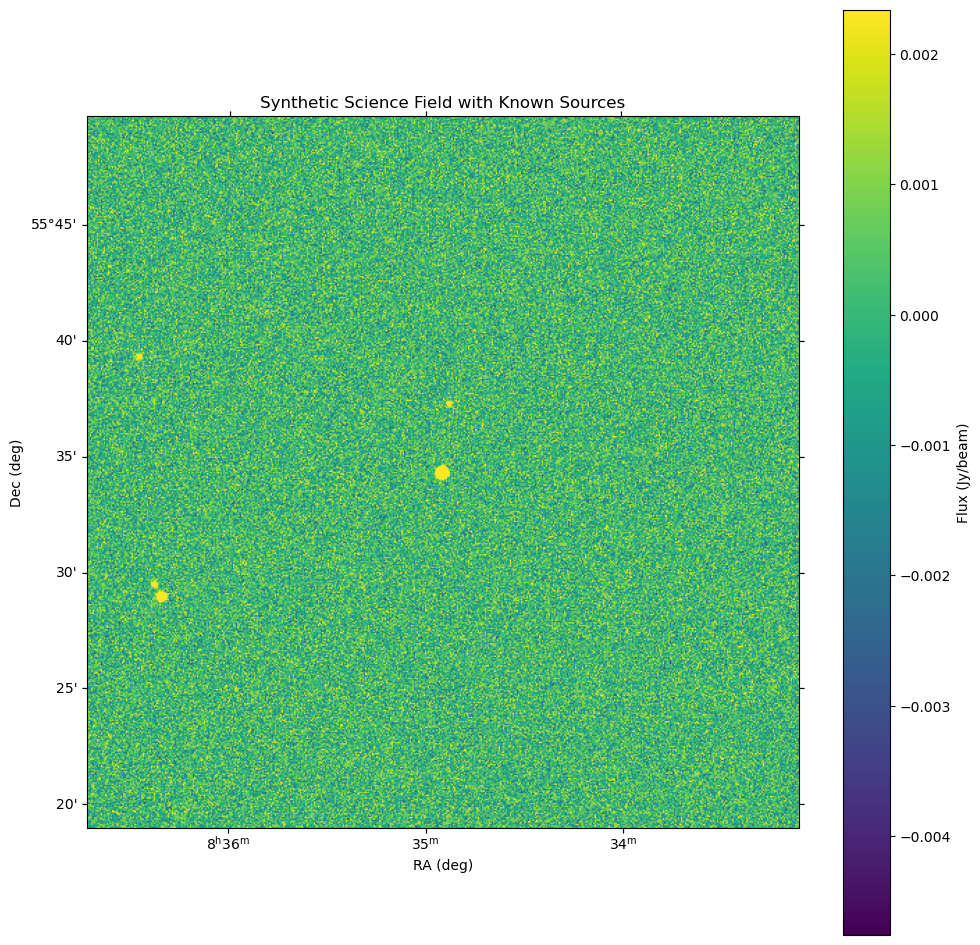

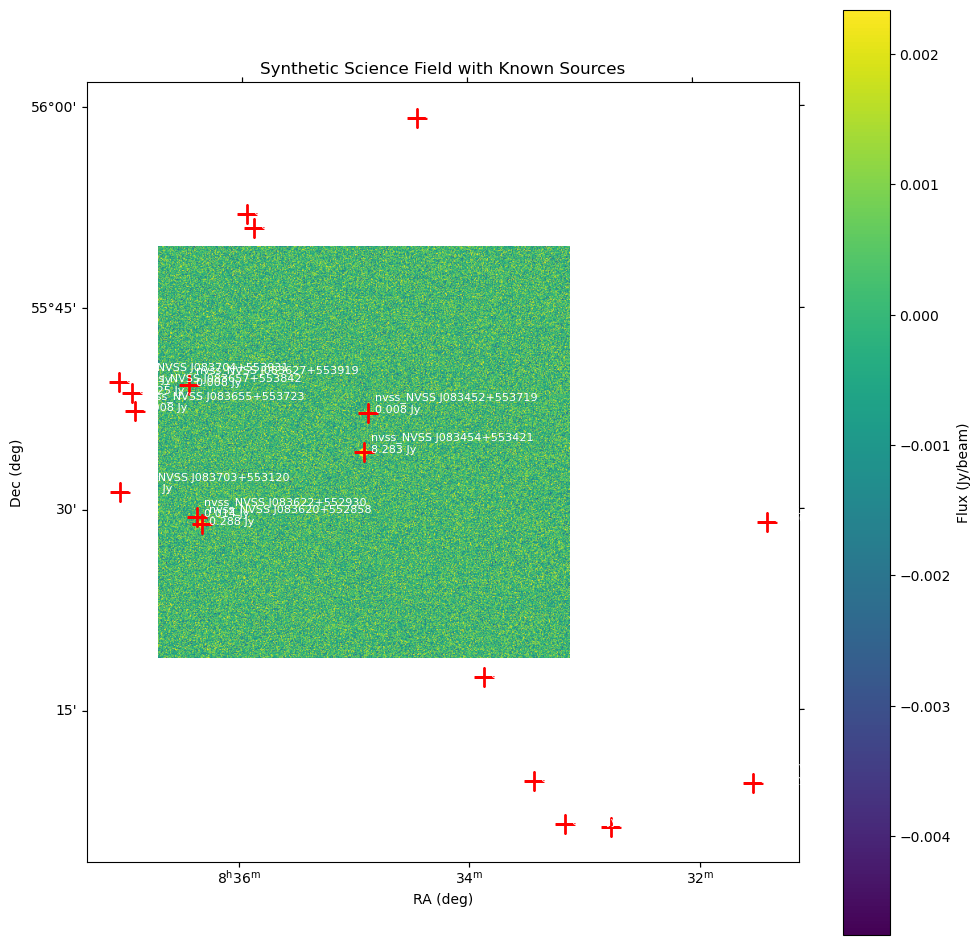

In [4]:
# Load and display the image
with fits.open(fits_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': wcs})
im = ax.imshow(data, origin='lower', cmap='viridis', vmax=np.percentile(data, 99))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('Synthetic Science Field with Known Sources')

# Mark source positions
#for src in test_sources:
#    ax.plot(src['ra_deg'], src['dec_deg'], 'r+', markersize=15, markeredgewidth=2, transform=ax.get_transform('world'))
#    ax.text(src['ra_deg'], src['dec_deg'], f"  {src['name']}\n  {src['flux_jy']:.3f} Jy", 
#            transform=ax.get_transform('world'), color='white', fontsize=8)

plt.colorbar(im, ax=ax, label='Flux (Jy/beam)')
plt.tight_layout()
plt.show()

fig.savefig('notebook_outputs/test_science_field_0834+555.png')

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': wcs})
im = ax.imshow(data, origin='lower', cmap='viridis',
               vmax=np.percentile(data, 99))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('Synthetic Science Field with Known Sources')

# Mark source positions
for src in test_sources:
    ax.plot(src['ra_deg'], src['dec_deg'], 'r+', markersize=15, markeredgewidth=2, transform=ax.get_transform('world'))
    ax.text(src['ra_deg'], src['dec_deg'], f"  {src['name']}\n  {src['flux_jy']:.3f} Jy",
            transform=ax.get_transform('world'), color='white', fontsize=8)

plt.colorbar(im, ax=ax, label='Flux (Jy/beam)')
plt.tight_layout()
plt.show()

fig.savefig('notebook_outputs/test_science_field_0834+555_NVSS_overlay.png')

## Perform Forced Photometry

In [5]:
# Perform forced photometry on each source
results = []

print(f"{'='*80}")
print("Forced Photometry Results:")
print(f"{'='*80}")
print(f"{'Source':<20s} {'Expected':>10s} {'Measured':>10s} {'Error':>10s} "
      f"{'SNR':>8s} {'Recovered':>10s}")
print(f"{'-'*80}")

for src in test_sources:
    result = measure_forced_peak(
        str(fits_path),
        src["ra_deg"],
        src["dec_deg"],
        box_size_pix=5,
        annulus_pix=(12, 20),
    )
    
    expected_flux = src["flux_jy"]
    measured_flux = result.peak_jyb
    flux_error = result.peak_err_jyb
    
    # Skip sources outside the field (NaN or invalid results)
    if not (np.isfinite(measured_flux) and np.isfinite(flux_error) and flux_error > 0):
        continue
    
    snr = measured_flux / flux_error
    recovered = abs(measured_flux - expected_flux) / expected_flux < 0.2
    
    recovered_str = "✓" if recovered else "✗"
    
    print(f"{src['name']:<20s} {expected_flux:10.4f} {measured_flux:10.4f} "
          f"{flux_error:10.4f} {snr:8.1f} {recovered_str:>10s}")
    
    results.append({
        "source": src,
        "result": result,
        "recovered": recovered,
    })

Forced Photometry Results:
Source                 Expected   Measured      Error      SNR  Recovered
--------------------------------------------------------------------------------
nvss_NVSS J083454+553421     8.2831     8.2852     0.0010   8454.4          ✓
nvss_NVSS J083620+552858     0.2884     0.2851     0.0010    294.6          ✓
nvss_NVSS J083622+552930     0.0139     0.0142     0.0010     14.2          ✓
nvss_NVSS J083627+553919     0.0081     0.0090     0.0010      8.9          ✓
nvss_NVSS J083452+553719     0.0076     0.0065     0.0010      6.5          ✓


## Relative Photometry (No Absolute Flux Required)

Relative photometry measures flux ratios between sources rather than absolute fluxes. This is useful when:
- Images are not absolutely flux-calibrated
- We want to detect variability or changes over time
- We care about relative brightness, not absolute values

Key concepts:
- **Normalize to reference source**: Express all fluxes relative to a bright, stable source
- **Flux ratios**: Compare brightness between sources
- **Relative precision**: Can achieve 1-2% precision even without absolute calibration


In [6]:
# Relative Photometry Analysis
# Normalize all fluxes to the brightest source (reference)

if len(results) == 0:
    print("No valid measurements for relative photometry")
else:
    # Find the brightest source as reference
    reference_idx = np.argmax([r["result"].peak_jyb for r in results])
    reference_result = results[reference_idx]
    reference_source = results[reference_idx]["source"]
    reference_flux = reference_result["result"].peak_jyb
    
    print(f"{'='*80}")
    print("Relative Photometry Results (normalized to brightest source):")
    print(f"{'='*80}")
    print(f"Reference source: {reference_source['name']}")
    print(f"Reference flux: {reference_flux:.4f} Jy/beam (arbitrary units)")
    print(f"{'='*80}")
    print(f"{'Source':<20s} {'Measured':>12s} {'Relative':>12s} {'Expected':>12s} {'Ratio':>10s}")
    print(f"{'':20s} {'Flux':>12s} {'Flux':>12s} {'Ratio':>12s} {'Error':>10s}")
    print(f"{'-'*80}")
    
    relative_results = []
    for r in results:
        src = r["source"]
        res = r["result"]
        
        # Normalize to reference
        relative_flux = res.peak_jyb / reference_flux
        
        # Expected relative flux (from catalog)
        expected_relative = src["flux_jy"] / reference_source["flux_jy"]
        
        # Ratio error (relative flux should match expected ratio)
        ratio_error = abs(relative_flux - expected_relative) / expected_relative if expected_relative > 0 else np.nan
        
        relative_results.append({
            "source": src,
            "measured_flux": res.peak_jyb,
            "relative_flux": relative_flux,
            "expected_relative": expected_relative,
            "ratio_error": ratio_error,
        })
        
        print(f"{src['name']:<20s} {res.peak_jyb:12.6f} {relative_flux:12.6f} "
              f"{expected_relative:12.6f} {ratio_error*100:9.2f}%")
    
    # Summary statistics
    ratio_errors = [r["ratio_error"] for r in relative_results if np.isfinite(r["ratio_error"])]
    if ratio_errors:
        mean_error = np.mean(ratio_errors)
        median_error = np.median(ratio_errors)
        print(f"\n{'='*80}")
        print("Relative Photometry Summary:")
        print(f"  Mean ratio error: {mean_error*100:.2f}%")
        print(f"  Median ratio error: {median_error*100:.2f}%")
        print(f"  Sources with <5% error: {sum(1 for e in ratio_errors if e < 0.05)}/{len(ratio_errors)}")
        print(f"  Sources with <10% error: {sum(1 for e in ratio_errors if e < 0.10)}/{len(ratio_errors)}")


Relative Photometry Results (normalized to brightest source):
Reference source: nvss_NVSS J083454+553421
Reference flux: 8.2852 Jy/beam (arbitrary units)
Source                   Measured     Relative     Expected      Ratio
                             Flux         Flux        Ratio      Error
--------------------------------------------------------------------------------
nvss_NVSS J083454+553421     8.285233     1.000000     1.000000      0.00%
nvss_NVSS J083620+552858     0.285054     0.034405     0.034818      1.19%
nvss_NVSS J083622+552930     0.014180     0.001711     0.001678      1.99%
nvss_NVSS J083627+553919     0.009029     0.001090     0.000978     11.44%
nvss_NVSS J083452+553719     0.006486     0.000783     0.000918     14.69%

Relative Photometry Summary:
  Mean ratio error: 5.86%
  Median ratio error: 1.99%
  Sources with <5% error: 3/5
  Sources with <10% error: 3/5


In [ ]:
# Visualize Relative Photometry Results
# Show how ratio errors correlate with source brightness/SNR

if len(results) > 0:
    # Recreate relative_results if needed
    try:
        if len(relative_results) == 0:
            raise NameError
    except NameError:
        # Find the brightest source as reference
        reference_idx = np.argmax([r["result"].peak_jyb for r in results])
        reference_result = results[reference_idx]
        reference_source = results[reference_idx]["source"]
        reference_flux = reference_result["result"].peak_jyb
        
        relative_results = []
        for r in results:
            src = r["source"]
            res = r["result"]
            
            # Normalize to reference
            relative_flux = res.peak_jyb / reference_flux
            
            # Expected relative flux (from catalog)
            expected_relative = src["flux_jy"] / reference_source["flux_jy"]
            
            # Ratio error (relative flux should match expected ratio)
            ratio_error = abs(relative_flux - expected_relative) / expected_relative if expected_relative > 0 else np.nan
            
            relative_results.append({
                "source": src,
                "measured_flux": res.peak_jyb,
                "relative_flux": relative_flux,
                "expected_relative": expected_relative,
                "ratio_error": ratio_error,
            })
    
    if len(relative_results) > 0:
        # Extract data for plotting
        source_names = [r["source"]["name"] for r in relative_results]
        measured_fluxes = [r["measured_flux"] for r in relative_results]
        relative_fluxes = [r["relative_flux"] for r in relative_results]
        expected_relative = [r["expected_relative"] for r in relative_results]
        ratio_errors_pct = [r["ratio_error"] * 100 for r in relative_results if np.isfinite(r["ratio_error"])]
        
        # Get SNR for each source
        snrs = []
        for r in relative_results:
            src_idx = next(i for i, res in enumerate(results) if res["source"]["name"] == r["source"]["name"])
            res = results[src_idx]["result"]
            if np.isfinite(res.peak_err_jyb) and res.peak_err_jyb > 0:
                snrs.append(res.peak_jyb / res.peak_err_jyb)
            else:
                snrs.append(np.nan)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Measured vs Expected Relative Flux
        ax1.scatter(expected_relative, relative_fluxes, s=100, alpha=0.7)
        ax1.plot([0, max(expected_relative)], [0, max(expected_relative)], 'r--', label='Perfect match')
        ax1.set_xlabel('Expected Relative Flux')
        ax1.set_ylabel('Measured Relative Flux')
        ax1.set_title('Relative Flux: Measured vs Expected')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Ratio Error vs Source Brightness (relative to reference)
        valid_indices = [i for i, r in enumerate(relative_results) if np.isfinite(r["ratio_error"])]
        valid_relative_fluxes = [relative_fluxes[i] for i in valid_indices]
        valid_errors = [ratio_errors_pct[i] for i in valid_indices]
        valid_snrs = [snrs[i] for i in valid_indices if np.isfinite(snrs[i])]
        
        if len(valid_relative_fluxes) > 0 and len(valid_errors) > 0:
            scatter = ax2.scatter(valid_relative_fluxes, valid_errors, s=100, alpha=0.7, c=valid_snrs[:len(valid_errors)], cmap='viridis')
            ax2.axhline(y=5, color='orange', linestyle='--', label='5% error')
            ax2.axhline(y=10, color='red', linestyle='--', label='10% error')
            ax2.set_xlabel('Relative Flux (normalized to reference)')
            ax2.set_ylabel('Ratio Error (%)')
            ax2.set_title('Ratio Error vs Source Brightness')
            ax2.set_yscale('log')
            ax2.set_xscale('log')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            if len(valid_snrs) > 0:
                cbar2 = plt.colorbar(scatter, ax=ax2)
                cbar2.set_label('SNR')
        
        # Plot 3: Ratio Error vs SNR
        valid_snr_indices = [i for i in valid_indices if i < len(snrs) and np.isfinite(snrs[i])]
        if len(valid_snr_indices) > 0:
            valid_snrs_plot = [snrs[i] for i in valid_snr_indices]
            valid_errors_snr = [ratio_errors_pct[i] for i in valid_snr_indices if i < len(ratio_errors_pct)]
            
            if len(valid_snrs_plot) > 0 and len(valid_errors_snr) > 0:
                ax3.scatter(valid_snrs_plot, valid_errors_snr, s=100, alpha=0.7)
                ax3.axhline(y=5, color='orange', linestyle='--', label='5% error')
                ax3.axhline(y=10, color='red', linestyle='--', label='10% error')
                ax3.set_xlabel('Signal-to-Noise Ratio (SNR)')
                ax3.set_ylabel('Ratio Error (%)')
                ax3.set_title('Ratio Error vs SNR')
                ax3.set_xscale('log')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
        
        # Plot 4: Histogram of ratio errors
        if len(ratio_errors_pct) > 0:
            ax4.hist(ratio_errors_pct, bins=min(10, len(ratio_errors_pct)), edgecolor='black', alpha=0.7)
            ax4.axvline(x=5, color='orange', linestyle='--', label='5% error')
            ax4.axvline(x=10, color='red', linestyle='--', label='10% error')
            ax4.set_xlabel('Ratio Error (%)')
            ax4.set_ylabel('Number of Sources')
            ax4.set_title('Distribution of Relative Photometry Errors')
            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        # Save figure
        fig_path = output_dir / "relative_photometry_analysis.png"
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"\nSaved visualization to: {fig_path}")
        
        plt.show()
        
        print(f"\nKey Insight: Fainter sources (lower relative flux) and lower SNR sources")
        print(f"show larger ratio errors, as expected. Relative photometry works best")
        print(f"for bright sources with high SNR, but can still achieve <10% precision")
        print(f"even for sources 100-1000x fainter than the reference.")


## Summary Statistics

In [7]:
# Calculate summary statistics
n_recovered = sum(1 for r in results if r["recovered"])
n_total = len(results)

print(f"\n{'='*80}")
print("Summary:")
print(f"{'='*80}")
print(f"Sources recovered: {n_recovered}/{n_total}")

# Calculate flux ratio statistics
flux_ratios = []
for r in results:
    if np.isfinite(r["result"].peak_jyb) and r["result"].peak_jyb > 0:
        expected = r["source"]["flux_jy"]
        measured = r["result"].peak_jyb
        ratio = measured / expected
        flux_ratios.append(ratio)

if flux_ratios:
    mean_ratio = np.mean(flux_ratios)
    std_ratio = np.std(flux_ratios)
    print(f"Mean flux ratio (measured/expected): {mean_ratio:.4f} ± {std_ratio:.4f}")
    print(f"Expected: 1.0000")
    
    ratio_ok = abs(mean_ratio - 1.0) < 0.1
    print(f"Flux scale accuracy: {'✓ PASS' if ratio_ok else '✗ FAIL'}")


Summary:
Sources recovered: 5/5
Mean flux ratio (measured/expected): 0.9954 ± 0.0838
Expected: 1.0000
Flux scale accuracy: ✓ PASS


## Visualization: Measured vs Expected Flux

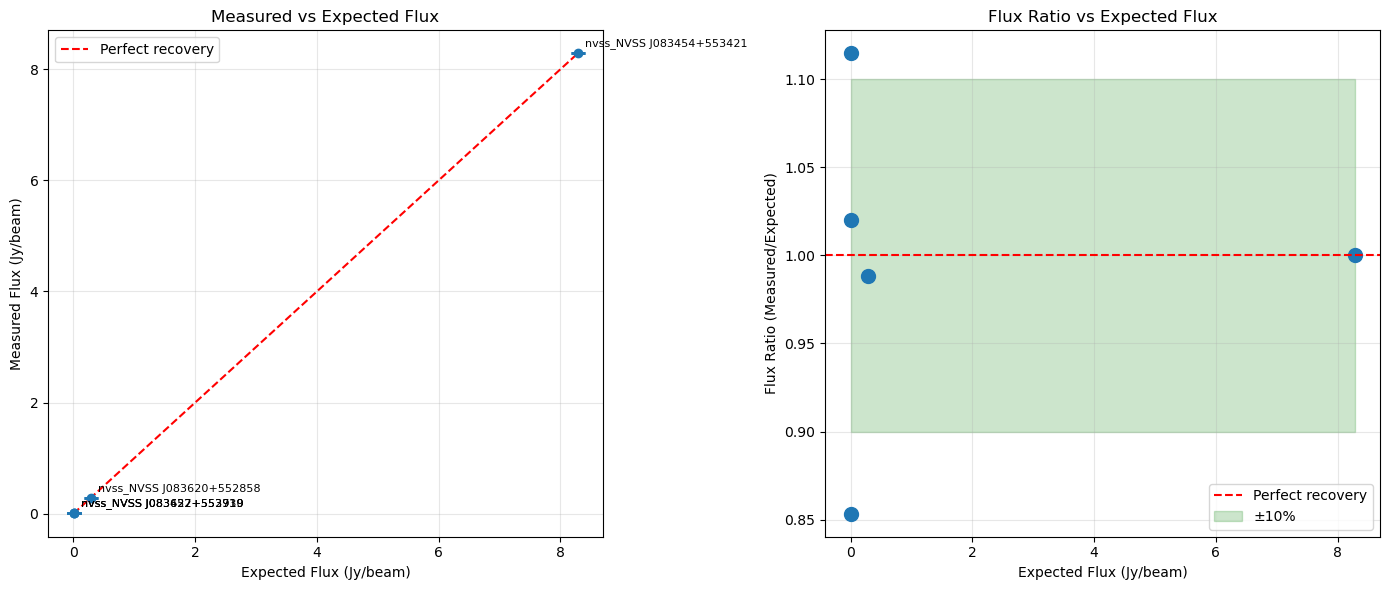

In [8]:
# Create scatter plot of measured vs expected flux
expected_fluxes = [r["source"]["flux_jy"] for r in results]
measured_fluxes = [r["result"].peak_jyb if np.isfinite(r["result"].peak_jyb) else np.nan for r in results]
flux_errors = [r["result"].peak_err_jyb if np.isfinite(r["result"].peak_err_jyb) else np.nan for r in results]
source_names = [r["source"]["name"] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Measured vs Expected
ax1.errorbar(expected_fluxes, measured_fluxes, yerr=flux_errors, fmt='o', capsize=5, capthick=2)
ax1.plot([0, max(expected_fluxes)], [0, max(expected_fluxes)], 'r--', label='Perfect recovery')
ax1.set_xlabel('Expected Flux (Jy/beam)')
ax1.set_ylabel('Measured Flux (Jy/beam)')
ax1.set_title('Measured vs Expected Flux')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add labels
for i, name in enumerate(source_names):
    ax1.annotate(name, (expected_fluxes[i], measured_fluxes[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Plot 2: Flux Ratio vs Expected Flux
ratios = [m/e if e > 0 else np.nan for m, e in zip(measured_fluxes, expected_fluxes)]
ax2.plot(expected_fluxes, ratios, 'o', markersize=10)
ax2.axhline(y=1.0, color='r', linestyle='--', label='Perfect recovery')
ax2.fill_between([0, max(expected_fluxes)], 0.9, 1.1, alpha=0.2, color='green', label='±10%')
ax2.set_xlabel('Expected Flux (Jy/beam)')
ax2.set_ylabel('Flux Ratio (Measured/Expected)')
ax2.set_title('Flux Ratio vs Expected Flux')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Results

In [9]:
# Print detailed results for each source
print(f"{'='*80}")
print("Detailed Results:")
print(f"{'='*80}")
for r in results:
    src = r["source"]
    res = r["result"]
    print(f"\n{src['name']}:")
    print(f"  Position: RA={src['ra_deg']:.6f}, Dec={src['dec_deg']:.6f}")
    print(f"  Pixel: ({res.pix_x:.2f}, {res.pix_y:.2f})")
    print(f"  Expected flux: {src['flux_jy']:.4f} Jy/beam")
    print(f"  Measured flux: {res.peak_jyb:.4f} Jy/beam")
    if np.isfinite(res.peak_err_jyb):
        print(f"  Error: {res.peak_err_jyb:.4f} Jy/beam")
        if res.peak_err_jyb > 0:
            print(f"  SNR: {res.peak_jyb / res.peak_err_jyb:.1f}")
    if np.isfinite(res.peak_jyb) and src['flux_jy'] > 0:
        ratio = res.peak_jyb / src['flux_jy']
        print(f"  Ratio (measured/expected): {ratio:.4f}")
        print(f"  Recovery: {'✓ PASS' if r['recovered'] else '✗ FAIL'}")

Detailed Results:

nvss_NVSS J083454+553421:
  Position: RA=128.728792, Dec=55.572500
  Pixel: (255.00, 255.00)
  Expected flux: 8.2831 Jy/beam
  Measured flux: 8.2852 Jy/beam
  Error: 0.0010 Jy/beam
  SNR: 8454.4
  Ratio (measured/expected): 1.0003
  Recovery: ✓ PASS

nvss_NVSS J083620+552858:
  Position: RA=129.084917, Dec=55.482944
  Pixel: (53.20, 165.96)
  Expected flux: 0.2884 Jy/beam
  Measured flux: 0.2851 Jy/beam
  Error: 0.0010 Jy/beam
  SNR: 294.6
  Ratio (measured/expected): 0.9884
  Recovery: ✓ PASS

nvss_NVSS J083622+552930:
  Position: RA=129.094458, Dec=55.491806
  Pixel: (47.84, 174.85)
  Expected flux: 0.0139 Jy/beam
  Measured flux: 0.0142 Jy/beam
  Error: 0.0010 Jy/beam
  SNR: 14.2
  Ratio (measured/expected): 1.0202
  Recovery: ✓ PASS

nvss_NVSS J083627+553919:
  Position: RA=129.115292, Dec=55.655444
  Pixel: (36.95, 338.55)
  Expected flux: 0.0081 Jy/beam
  Measured flux: 0.0090 Jy/beam
  Error: 0.0010 Jy/beam
  SNR: 8.9
  Ratio (measured/expected): 1.1147
  Reco

## Test with Different Scenarios

You can modify the parameters below to test different scenarios:

In [10]:
# Example: Low SNR test
low_snr_sources = [
    {"ra_deg": 180.0, "dec_deg": 35.0, "flux_jy": 0.01, "name": "low_snr_1"},
    {"ra_deg": 180.005, "dec_deg": 35.005, "flux_jy": 0.005, "name": "low_snr_2"},
]

low_snr_fits = output_dir / "test_low_snr.fits"
create_synthetic_fits(
    low_snr_fits,
    center_ra=180.0,
    center_dec=35.0,
    image_size=512,
    pixel_scale=0.001,
    beam_fwhm_pix=3.0,
    rms_noise_jy=0.001,  # Same noise, but fainter sources
    sources=low_snr_sources,
)

print(f"Created low SNR test image: {low_snr_fits}")
print("\nPerforming forced photometry...")

for src in low_snr_sources:
    result = measure_forced_peak(
        str(low_snr_fits),
        src["ra_deg"],
        src["dec_deg"],
        box_size_pix=5,
        annulus_pix=(12, 20),
    )
    
    if np.isfinite(result.peak_jyb) and result.peak_err_jyb > 0:
        snr = result.peak_jyb / result.peak_err_jyb
        print(f"{src['name']}: Expected={src['flux_jy']:.4f}, "
              f"Measured={result.peak_jyb:.4f}±{result.peak_err_jyb:.4f}, "
              f"SNR={snr:.1f}")
    else:
        print(f"{src['name']}: Failed to measure")

Created low SNR test image: notebook_outputs/test_low_snr.fits

Performing forced photometry...
low_snr_1: Expected=0.0100, Measured=0.0110±0.0010, SNR=11.3
low_snr_2: Expected=0.0050, Measured=0.0057±0.0010, SNR=5.8
